<a href="https://colab.research.google.com/github/AHamamd150/ML_Course_BUE/blob/main/BUE_2024/codes/Generate_AnimeFaces_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from keras.datasets import mnist
#from keras.utils.vis_utils import plot_model
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy
import os
import glob
import cv2 as CV
from sklearn.preprocessing import MinMaxScaler

# To understand the VAE, we need to try the coding for the autoencoder first

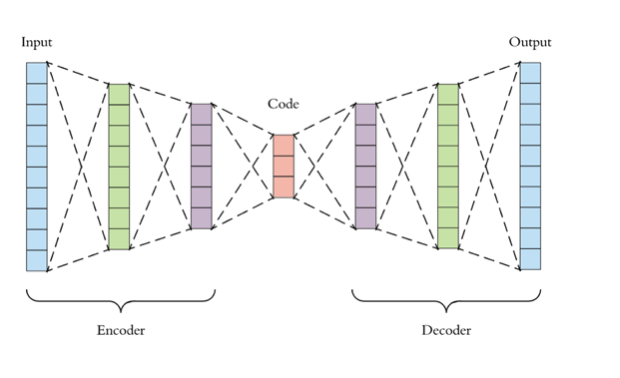

# Let't try the convolution autoencoder for the digit MNIST dataset

In [20]:
data=mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


# Visulaize, visulaize, visualize .....

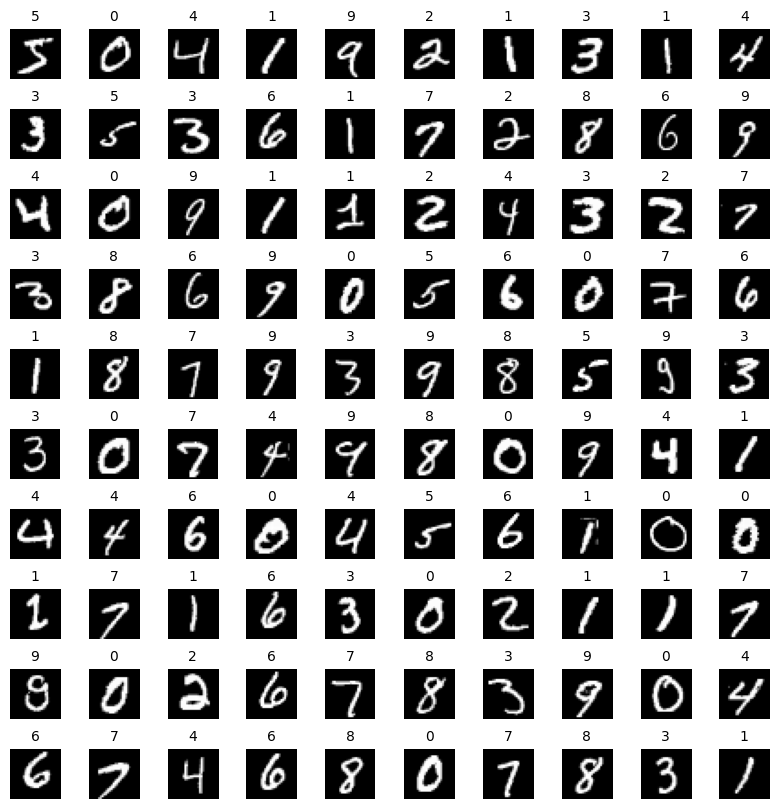

In [22]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace = 0.6)
for q in range(100):
  fig.add_subplot(10,10,q+1)
  plt.imshow(x_train[q],cmap='gray');
  plt.title(y_train[q],fontsize=10)
  plt.axis('off')


Normalize the images, as we learned from the previous lectures

In [23]:
x_train=x_train.reshape(-1,28,28,1)/255;
x_test=x_test.reshape(-1,28,28,1)/255;

# Build the convolution autoencoder network

In [45]:
####### In this network, we construct the encoder and the decoder separately.

def encoder():
    encoder1 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer1')(encoder_input)
    encoder2 = layers.MaxPooling2D((2,2),padding='same')(encoder1)
    encoder3 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer2')(encoder2)
    encoder4 = layers.MaxPooling2D((2,2),padding='same')(encoder3)
    encoder5 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer3')(encoder4)
    encoder6 = layers.Flatten()(encoder5)
    encoder_output = layers.Dense(latent,activation=None,name='layer4')(encoder6)
    encoder_model= Model(encoder_input,encoder_output)
    return encoder_model
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = layers.Dense(392,activation=None,name='layer5')(decoder_input)
    decoder2 = layers.Reshape((7,7,8))(decoder1)
    decoder3 = layers.Conv2D(8,kernel_size=2,padding='same',activation='relu',name='layer6')(decoder2)
    decoder4 = layers.UpSampling2D((2,2))(decoder3)
    decoder5 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer7')(decoder4)
    decoder6 = layers.UpSampling2D((2,2))(decoder5)
    decoder_output = layers.Conv2D(1,kernel_size=2,activation='relu',padding='same',name='layer8')(decoder6)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model


latent=64 # dimension of the latent space
encoder_input = keras.Input(shape=(28,28,1))
autoencoder=Model(encoder_input,decoder()(encoder()(encoder_input)))


In [46]:
autoencoder.compile(optimizer=Adam(),loss='mse',metrics=['accuracy'])
encoder().summary(),decoder().summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 layer1 (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 layer2 (Conv2D)             (None, 14, 14, 8)         1032      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                                 
 layer3 (Conv2D)             (None, 7, 7, 8)           264

(None, None)

# Train the network. In this network we fit the network to minimize the difference between the input data and itself.

In [47]:
autoencoder.fit(x_train,x_train,epochs=10,batch_size=100,validation_split=0.2)


Epoch 1/10
480/480 [==============================] - 6s 7ms/step - loss: 0.0259 - accuracy: 0.8089 - val_loss: 0.0125 - val_accuracy: 0.8135
Epoch 2/10
480/480 [==============================] - 4s 8ms/step - loss: 0.0108 - accuracy: 0.8133 - val_loss: 0.0095 - val_accuracy: 0.8145
Epoch 3/10
480/480 [==============================] - 3s 6ms/step - loss: 0.0089 - accuracy: 0.8139 - val_loss: 0.0084 - val_accuracy: 0.8149
Epoch 4/10
480/480 [==============================] - 3s 6ms/step - loss: 0.0079 - accuracy: 0.8141 - val_loss: 0.0076 - val_accuracy: 0.8150
Epoch 5/10
480/480 [==============================] - 3s 6ms/step - loss: 0.0072 - accuracy: 0.8143 - val_loss: 0.0070 - val_accuracy: 0.8151
Epoch 6/10
480/480 [==============================] - 4s 8ms/step - loss: 0.0067 - accuracy: 0.8144 - val_loss: 0.0067 - val_accuracy: 0.8152
Epoch 7/10
480/480 [==============================] - 3s 6ms/step - loss: 0.0064 - accuracy: 0.8145 - val_loss: 0.0063 - val_accuracy: 0.8153
Epoch 

# Do some prediction

In [48]:
y_pred=autoencoder.predict(x_test[0].reshape(-1,28,28,1))

1/1 [==============================] - 0s 307ms/step


# Plot the network prediction

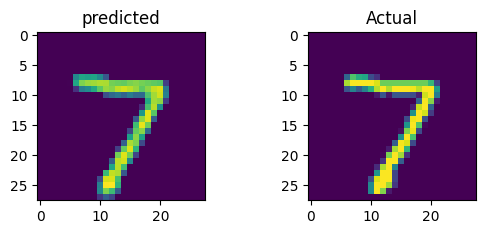

In [49]:
fig = plt.figure()
fig.add_subplot(221)
plt.imshow(y_pred.reshape(28,28));
plt.title('predicted');
fig.add_subplot(222);
plt.imshow(x_test[0,:,:,0]);
plt.title('Actual');

# Now we understand how the autoencoder works. Let's see how the  VAE works

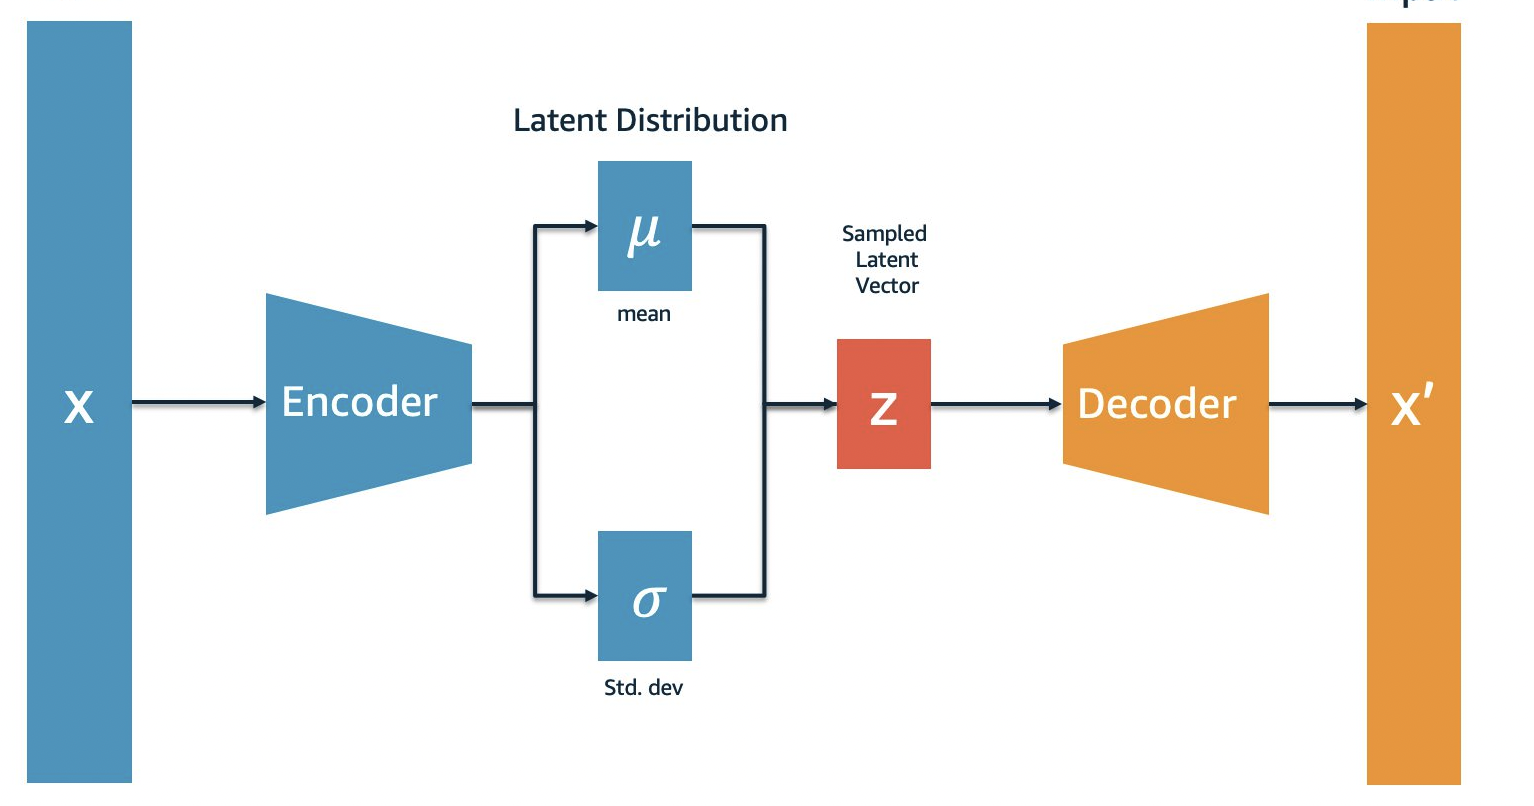

# Prepare the training data set

In [2]:
!git clone https://github.com/AHamamd150/Zewail-city.git

Cloning into 'Zewail-city'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 246 (delta 36), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (246/246), 34.32 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [3]:
os.system('unzip Zewail-city/data/Anime_images.zip');

# Read all images in OpenCV with gray scale and resize them to have 28*28 dimensions

In [4]:
data=glob.glob('Anime_images/*')
files=[]
for q in data:
  x1=CV.imread(q,0)
  x1=CV.resize(x1,(56,56))
  files.append(x1)

# Check some of the transformed images

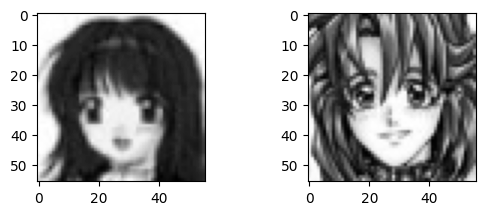

In [5]:
plt.subplot(221)
plt.imshow(files[0],cmap='gray');
plt.subplot(222)
plt.imshow(files[10],cmap='gray');

# Split into train and test samples

In [6]:
x_train= files[:450]
x_test = files[450:]


# Normalize the images


In [7]:
Scaler = MinMaxScaler()
x_train_transform,x_test_transform=[],[]
for q in range(len(x_train)):
    x_train_transform.append(Scaler.fit_transform(x_train[q]))
for q in range(len(x_test)):
    x_test_transform.append(Scaler.transform(x_test[q]))


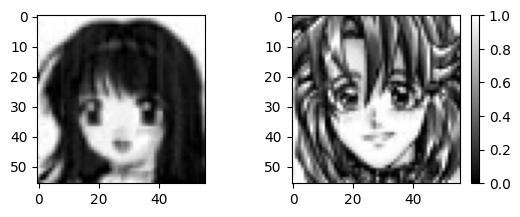

In [8]:
plt.subplot(221)
plt.imshow(x_train_transform[0].reshape(56,56),cmap='gray');
plt.subplot(222)
plt.imshow(x_train_transform[10].reshape(56,56),cmap='gray');
plt.colorbar();


In [9]:
x_train_transform = np.array(x_train_transform).reshape(-1,56,56,1)
x_test_transform = np.array(x_test_transform).reshape(-1,56,56,1)

# Define the GAE model

In [10]:
# Sampling the latent variable z from the mean and std of the last dense layer
def my_activation(x):
  return K.maximum(0.1,x)
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def encoder():
    encoder1 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same',name='layer1')(encoder_input)
    encoder2 = layers.MaxPooling2D((2,2),padding='same')(encoder1)
    encoder3 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same',name='layer2')(encoder2)
    encoder4 = layers.MaxPooling2D((2,2),padding='same')(encoder3)
    encoder5 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',name='layer3')(encoder4)
    encoder6 = layers.MaxPooling2D((2,2),padding='same')(encoder5)
    encoder7 = layers.Conv2D(8,kernel_size=2,activation='relu',padding='same',name='layer4')(encoder6)
    encoder8 = layers.Flatten()(encoder7)
    encoder_output = layers.Dense(decoder_inputdim,activation='relu',name='layer5')(encoder8)
    z_mean = layers.Dense(latent, name='z_mean')(encoder_output)
    z_log_var = layers.Dense(latent, name='z_log_var')(encoder_output)
    z = layers.Lambda(sampling, output_shape=(latent,), name='z')([z_mean, z_log_var])
    encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
    return encoder_model, z_mean, z_log_var



# define the decoder
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = layers.Dense(392,activation='relu',name='layer5')(decoder_input)
    decoder2 = layers.Reshape((7,7,8))(decoder1)
    decoder3 = layers.Conv2D(32,kernel_size=2,padding='same',activation='relu',name='layer6')(decoder2)
    decoder4 = layers.UpSampling2D((2,2))(decoder3)
    decoder5 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same',name='layer7')(decoder4)
    decoder6 = layers.UpSampling2D((2,2))(decoder5)

    decoder7 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same',name='layer8')(decoder6)
    decoder8 = layers.UpSampling2D((2,2))(decoder7)
    decoder_output = layers.Conv2D(1,kernel_size=2,padding='same',name='layer9')(decoder8)
    decoder_output = layers.Lambda(my_activation)(decoder_output)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model


In [11]:
latent=4
decoder_inputdim=392
encoder_input = keras.Input(shape=(56,56,1))
##########
encoder_model, z_mean, z_log_var = encoder()
decoder_model = decoder()
encoder_model.summary(),
decoder_model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 56, 56, 1)]          0         []                            
                                                                                                  
 layer1 (Conv2D)             (None, 56, 56, 64)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)           0         ['layer1[0][0]']              
 D)                                                                                               
                                                                                                  
 layer2 (Conv2D)             (None, 28, 28, 64)           16448     ['max_pooling2d[0][0]']   

In [12]:
outputs = decoder_model(encoder_model(encoder_input)[2])
VAE = Model(encoder_input,outputs,name='VAE')

In [13]:
def Loss(inputs,output):
    inputs = K.flatten(inputs)
    output= K.flatten(outputs)
    reconstruction_loss = mse(inputs, output)
    reconstruction_loss *= decoder_inputdim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    VAE_loss =K.mean(reconstruction_loss + kl_loss)
    return VAE_loss

VAE.add_loss(Loss(encoder_input,outputs))

In [14]:
VAE.compile(optimizer='adam',loss=None)
h= VAE.fit(x_train_transform,epochs=50,batch_size=5 ,validation_data=(x_test_transform, None))

Epoch 1/50
90/90 [==============================] - 12s 14ms/step - loss: 48.5875 - val_loss: 44.9479
Epoch 2/50
90/90 [==============================] - 1s 9ms/step - loss: 36.8603 - val_loss: 43.1148
Epoch 3/50
90/90 [==============================] - 1s 8ms/step - loss: 35.1166 - val_loss: 41.9398
Epoch 4/50
90/90 [==============================] - 1s 9ms/step - loss: 34.1292 - val_loss: 39.0861
Epoch 5/50
90/90 [==============================] - 1s 8ms/step - loss: 33.9716 - val_loss: 38.9987
Epoch 6/50
90/90 [==============================] - 1s 11ms/step - loss: 33.4049 - val_loss: 38.9382
Epoch 7/50
90/90 [==============================] - 1s 12ms/step - loss: 33.1869 - val_loss: 38.4406
Epoch 8/50
90/90 [==============================] - 1s 12ms/step - loss: 33.1265 - val_loss: 39.3031
Epoch 9/50
90/90 [==============================] - 1s 10ms/step - loss: 32.9856 - val_loss: 42.4529
Epoch 10/50
90/90 [==============================] - 1s 8ms/step - loss: 33.1570 - val_loss: 3

# check the latent space dimesions

3/3 [==============================] - 0s 4ms/step


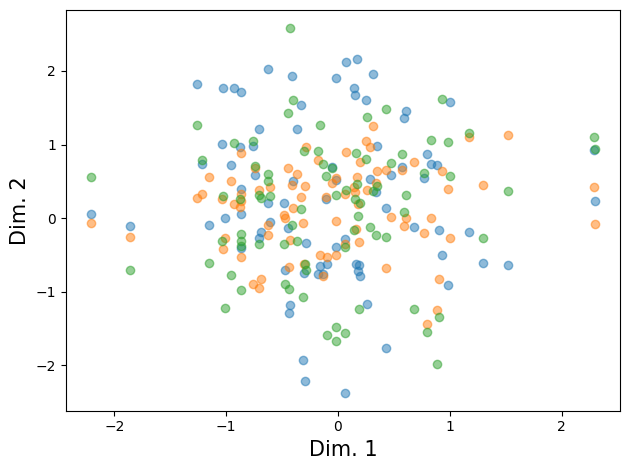

In [18]:
z_mean, _, _ = encoder_model.predict(x_test_transform)

plt.scatter(z_mean[:, 0], z_mean[:, 1],alpha=0.5);
plt.scatter(z_mean[:, 0], z_mean[:, 2],alpha=0.5);
plt.scatter(z_mean[:, 0], z_mean[:, 3],alpha=0.5);

plt.xlabel('Dim. 1',fontsize=15);
plt.ylabel('Dim. 2',fontsize=15);
plt.tight_layout()


# Now lets have fun geerating more anime faces from the latent space

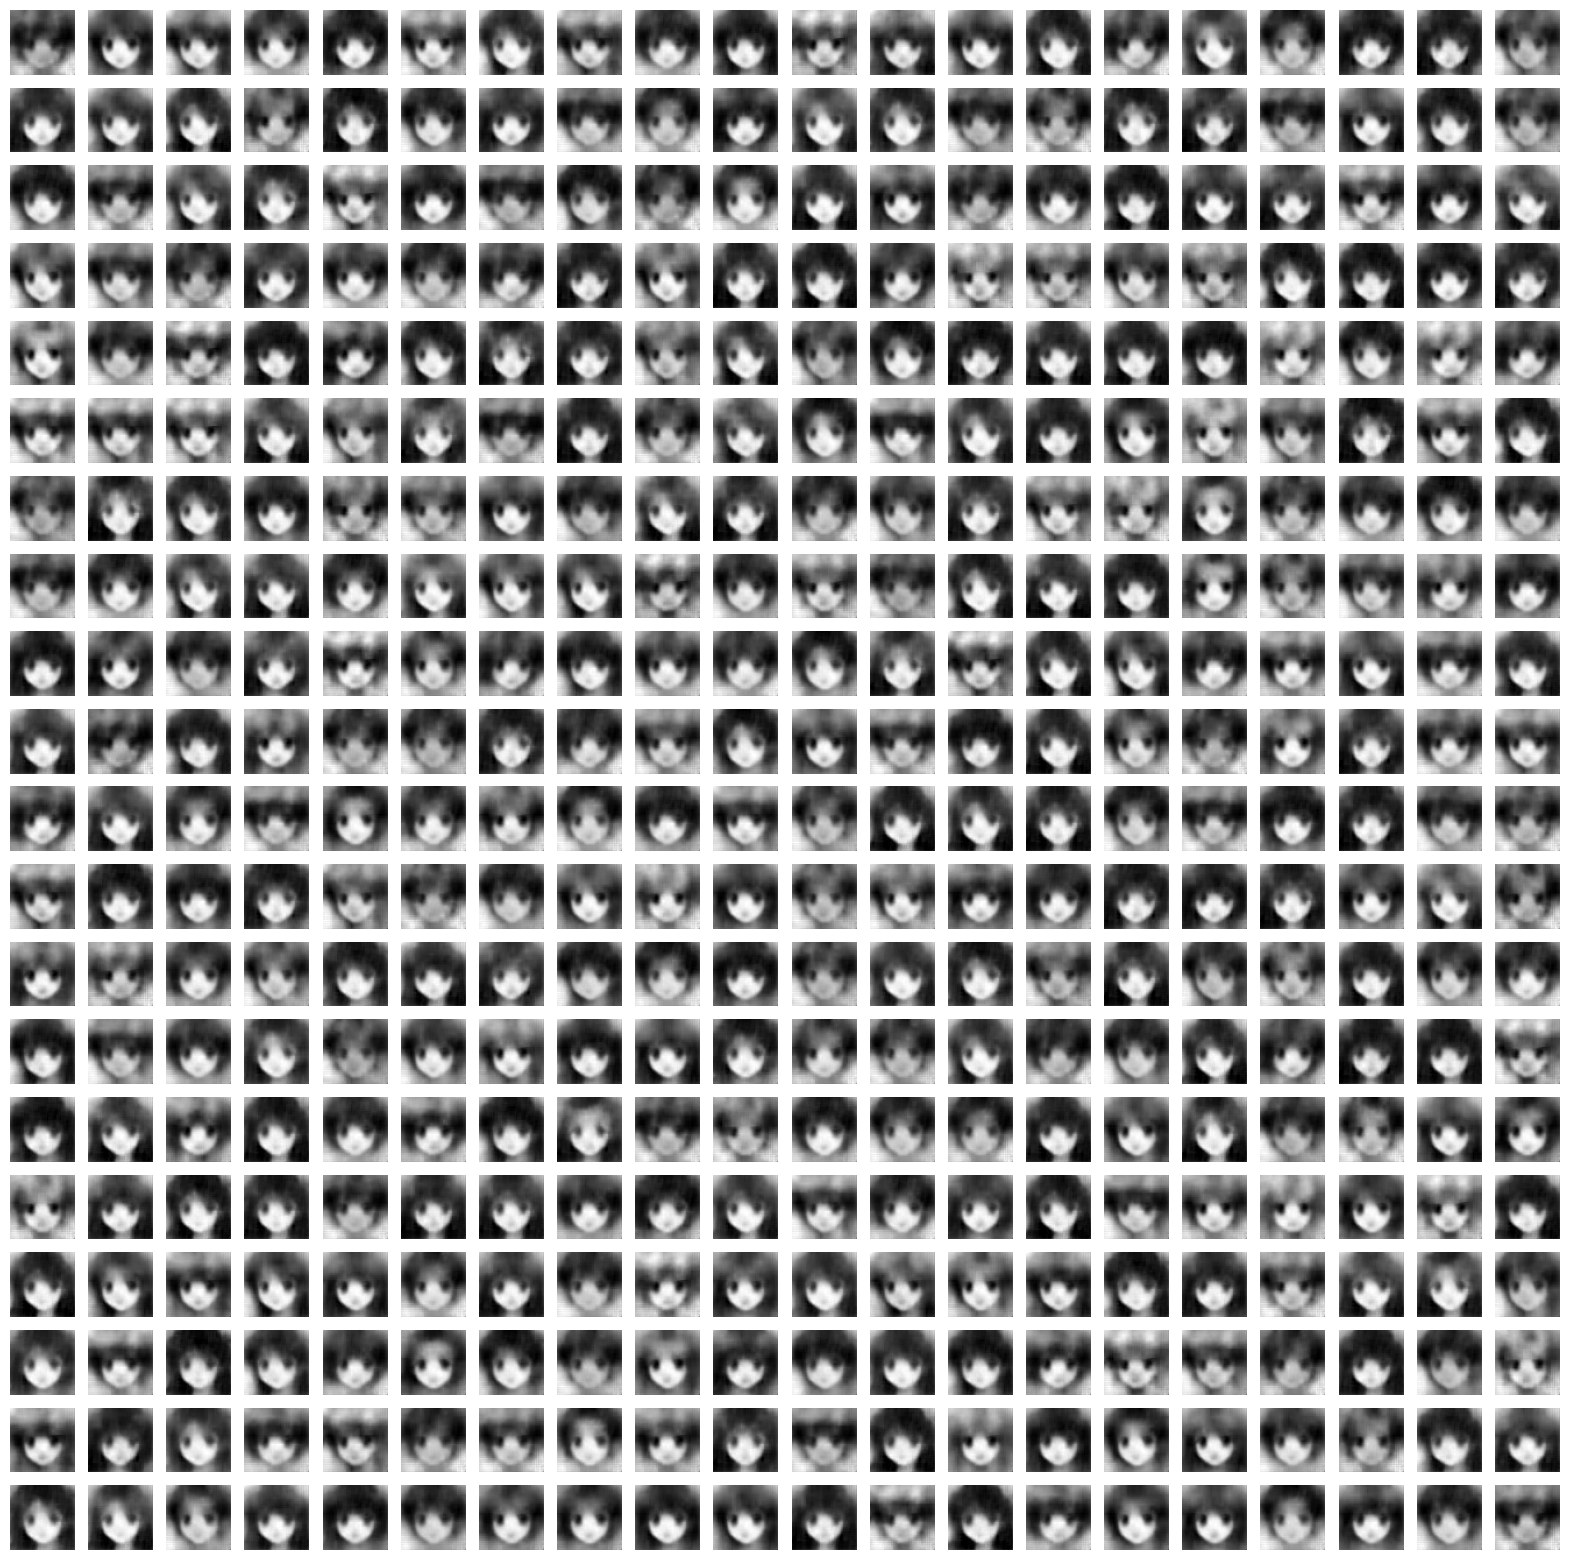

In [19]:
x1=np.random.uniform(-2,2,400)
x2=np.random.uniform(-3,3,400)
x3=np.random.uniform(-1.5,2,400)
x4=np.random.uniform(-1.,2,400)

fig  = plt.figure(figsize=(20,20))
for q in range(400):
  fig.add_subplot(20,20,q+1)
  y_pred=decoder_model.predict([[x1[q],x2[q],x3[q],x4[q]]],verbose=0);
  plt.imshow(y_pred.reshape(56,56)*255,cmap='gray');
  plt.axis('off')